#  Using Spark GraphX (Scala) to Explore Teams Meetings Connections

This is a script that attempts to analyse **Microsoft Teams** data and its users. Theis tool has been used to 

- determine which students interacted with teachers and other students during Lockdown
- the number of connections made by students during lockdown
- which students attended all of their parent teacher nights on Microsoft Teams

The final form of the data is pushed out for data visualisation; an anonymised image of which is produced below (reolution is kept low to hide names)


In [1]:
// Set log level to ERROR (less verbose)
sc.setLogLevel("ERROR")

Intitializing Scala interpreter ...

Spark Web UI available at http://489a97f9c416:4040
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1593493256710)
SparkSession available as 'spark'


In [2]:
import org.apache.spark.graphx._
import org.apache.spark.rdd.RDD

import org.apache.spark.graphx._
import org.apache.spark.rdd.RDD


In [56]:
import scala.util.hashing.MurmurHash3
import org.apache.spark.SparkContext._
import org.apache.spark._

import org.apache.spark.util.IntParam 

import org.apache.spark.graphx.util.GraphGenerators 

import scala.util.hashing.MurmurHash3
import org.apache.spark.SparkContext._
import org.apache.spark._
import org.apache.spark.util.IntParam
import org.apache.spark.graphx.util.GraphGenerators


## 0. Importing data from Teams Web Scrape


In [4]:
val df = spark  //teams data from webscrape (in github.com/mabs31614)
  .read
  .option("header","true")
  .csv("meetings_iterateIV.csv")

df: org.apache.spark.sql.DataFrame = [Name: string, Anon-hash: string ... 2 more fields]


## 1. All users as a flat map

In [5]:
val meetings_happen = df.select($"Anon-hash", $"Met with Anon-hash2")
  .flatMap(x => Iterable(x(0).toString, x(1).toString))

meetings_happen.show()

+--------------------+
|               value|
+--------------------+
|a6dd882a-3bcc-414...|
|2b33b1a9-11e2-4ad...|
|2178e5ca-c396-446...|
|2b33b1a9-11e2-4ad...|
|32b05a78-91ae-4dc...|
|2b33b1a9-11e2-4ad...|
|b09069b4-977a-4cc...|
|2b33b1a9-11e2-4ad...|
|c1628bbf-0426-4ba...|
|2b33b1a9-11e2-4ad...|
|3e446d19-ab8f-4c0...|
|2b33b1a9-11e2-4ad...|
|db73afa1-d7aa-485...|
|2b33b1a9-11e2-4ad...|
|1bad0edf-cb30-480...|
|2b33b1a9-11e2-4ad...|
|a6dd882a-3bcc-414...|
|2b33b1a9-11e2-4ad...|
|2178e5ca-c396-446...|
|2b33b1a9-11e2-4ad...|
+--------------------+
only showing top 20 rows



meetings_happen: org.apache.spark.sql.Dataset[String] = [value: string]


## 2. Hashing each member

In [48]:
val meetingVertices: RDD[(VertexId, String)] = meetings_happen
  .rdd
  .distinct()
  .map(x => (MurmurHash3.stringHash(x), x))

meeetingVertices.toDF.show()

+-----------+--------------------+
|         _1|                  _2|
+-----------+--------------------+
|  -11226283|0543ffa3-1da7-4f5...|
| -242275388|cf6b64b5-caa6-4a2...|
|-1534436217|9c6e7edc-7f66-476...|
| -501084297|d70cee9a-6659-469...|
| -399443434|1b76604d-973c-4a1...|
|-1491206084|2178e5ca-c396-446...|
| 1049739525|83126f26-4ed3-421...|
|-1186716245|df1e49f4-c94b-46e...|
|-1215475918|00111b40-dd90-4cd...|
|  890045020|35460092-f774-48f...|
| -824988155|5c227b02-77c6-459...|
|  913038510|fb35ba38-fd9d-44f...|
|-1880963488|5e492294-cfea-4e8...|
|-2005993431|e933e0e4-41a7-4f3...|
|  701371189|9f2c86f2-bfea-445...|
| -491376221|c16fa317-a231-47e...|
| -891377651|a193953b-e7be-474...|
| 1830736030|15fbd69b-ebcd-43b...|
| 1509966752|34752b28-ccd3-455...|
| 1350603974|3349b6d2-9c4d-453...|
+-----------+--------------------+
only showing top 20 rows



meetingVertices: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, String)] = MapPartitionsRDD[146] at map at <console>:39


In [7]:
//in case data is missing
val default = ("Missing")

default: String = Missing


## 3. Select Relevant Data

In [140]:
val meetswith = df.select($"Anon-hash",$"Date"
                          , $"Met with Anon-hash2")

meetswith.show()

+--------------------+--------------------+--------------------+
|           Anon-hash|                Date| Met with Anon-hash2|
+--------------------+--------------------+--------------------+
|a6dd882a-3bcc-414...|Jun 17, 2020, 8:1...|2b33b1a9-11e2-4ad...|
|2178e5ca-c396-446...|Jun 17, 2020, 8:1...|2b33b1a9-11e2-4ad...|
|32b05a78-91ae-4dc...|Jun 17, 2020, 8:0...|2b33b1a9-11e2-4ad...|
|b09069b4-977a-4cc...|Jun 17, 2020, 7:5...|2b33b1a9-11e2-4ad...|
|c1628bbf-0426-4ba...|Jun 17, 2020, 7:4...|2b33b1a9-11e2-4ad...|
|3e446d19-ab8f-4c0...|Jun 17, 2020, 7:3...|2b33b1a9-11e2-4ad...|
|db73afa1-d7aa-485...|Jun 17, 2020, 7:2...|2b33b1a9-11e2-4ad...|
|1bad0edf-cb30-480...|Jun 16, 2020, 5:0...|2b33b1a9-11e2-4ad...|
|a6dd882a-3bcc-414...|Jun 17, 2020, 8:1...|2b33b1a9-11e2-4ad...|
|2178e5ca-c396-446...|Jun 17, 2020, 8:1...|2b33b1a9-11e2-4ad...|
|32b05a78-91ae-4dc...|Jun 17, 2020, 8:0...|2b33b1a9-11e2-4ad...|
|b09069b4-977a-4cc...|Jun 17, 2020, 7:5...|2b33b1a9-11e2-4ad...|
|c1628bbf-0426-4ba...|Jun

meetswith: org.apache.spark.sql.DataFrame = [Anon-hash: string, Date: string ... 1 more field]


## 4. Count the weight of edges

In [145]:
val meetEdges = meetswith.map(x => ( (
        MurmurHash3.stringHash(x(0).toString),    // x._1._1 or 1st part of the key
        MurmurHash3.stringHash(x(2).toString)),   // x._1._2 or 2nd part of the key
        1)                                        // x._2    or value
    )
    .rdd
    .reduceByKey(_+_)                            // use a mapReduce to count all 
    .map(x => Edge(x._1._1, x._1._2, x._2))

meetEdges.toDF.show()

+-----------+-----------+----+
|      srcId|      dstId|attr|
+-----------+-----------+----+
| -480497222| 1997337454|   4|
| -689347565|-1338107648|   4|
| -161800269| 1310155991|   4|
|  855818853|-1088133319|   4|
| 1516269864|  628345161|   4|
|-1735814711|  221392448|   1|
|-2000910472| 1353039522|   4|
|  334932050| 2015546316|   1|
| 1350603974|  -54293009|   1|
|-2120849828| -486432159|   4|
| 1050046094|  -54293009|   1|
| -689347565| 1547628626|   4|
| -303982107|  199609406|   1|
| 1164407076|  -54293009|   1|
|   42493235|-1509472485|   4|
|-1712347268|   24672310|   1|
| 1055115870|  463128253|   4|
| 2052281350|  -54293009|   1|
|-1879337352|   24672310|   4|
| -343959261|-1509472485|   4|
+-----------+-----------+----+
only showing top 20 rows



meetEdges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[Int]] = MapPartitionsRDD[855] at map at <console>:52


In [63]:
val graph = Graph(meetingVertices, meetEdges, default)

graph: org.apache.spark.graphx.Graph[String,Int] = org.apache.spark.graphx.impl.GraphImpl@306dd65c


In [50]:
graph.vertices.filter{case (id, meetings_happen) => meetings_happen == "2b33b1a9-11e2-4ad7-9f19-c2c1d0e491d3" }.foreach(println)

(837991095,2b33b1a9-11e2-4ad7-9f19-c2c1d0e491d3)


## 5. a) Analysis: Students of Concern

We aim to identify students who have shown unusually low levels of engagement during covid lockdown period. We seek to find students who have met with less than three other peers/teachers during the lockdownb period

In [147]:
//students of concern
print("students of concern: less than 3 meetings in lockdown period\n")
graph.inDegrees.filter(u=>u._2<4).sortBy(_._2).foreach(println)

students of concern: less than 3 meetings in lockdown period
(1309934521,1)
(-401825308,1)
(1687057319,1)
(-2069136988,1)
(-505558248,1)
(513780699,1)
(252834296,1)
(631229833,1)
(-1821297042,1)
(1684354721,1)
(1727050932,1)
(-455575284,1)
(-1541313051,1)
(-627899379,1)
(289136151,1)
(-810650888,2)
(-1796855781,2)
(-769288802,2)
(-598044423,2)
(2106568317,2)
(-2101087778,2)
(741249320,3)
(-1056322281,3)
(80238912,3)
(-1829222230,3)


## 5. b) Analysis: Count the number of Meetings between Students/ Teachers

In [146]:
graph.triplets.map(triplet => triplet.attr
  + " Teams meetings Between "
  + triplet.srcAttr.take(5)
  + "... and " 
  + triplet.dstAttr.take(5)+"...").collect.sorted.reverse.take(10).foreach(println(_))

8 Teams meetings Between f8422... and ab0db...
8 Teams meetings Between e3db4... and ab0db...
8 Teams meetings Between c5ec3... and ab0db...
8 Teams meetings Between bcbb4... and ab0db...
8 Teams meetings Between 7ff90... and ab0db...
8 Teams meetings Between 4820e... and ab0db...
8 Teams meetings Between 2c41f... and ab0db...
4 Teams meetings Between fefe1... and e5603...
4 Teams meetings Between fde17... and 9f2ce...
4 Teams meetings Between fdda5... and fa971...


## 6. Visualisation of Graph (Low Res to Anonymise Data)

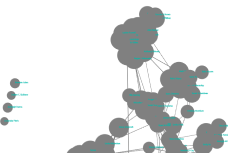

The graph above (a Power BI screenshpt which used the above Teams data) was used to identify students of concern (who had not been attending or engaging with online classes)